In [1]:
import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import re



In [2]:

raw_df = pd.read_excel("../frugal_model_results.xlsx", sheet_name="model_results")

# Function to extract numbers and convert to integers
def extract_params(param):
    match = re.search(r'\d+', param.replace('~', '').replace('–', ''))
    if match:
        return int(match.group()) * (1000 if 'K' in param else 1000000 if 'M' in param else 1)
    return 0

# Apply the function to the columns
raw_df['total_params_numeric'] = raw_df['total_params'].apply(extract_params)
raw_df['trainable_params_numeric'] = raw_df['trainable_params'].apply(extract_params)

# Plot Wh/F1

In [3]:
raw_df['wh_per_f1'] = (raw_df['energy_consumed_kwh']*1000)/raw_df['f1_score']

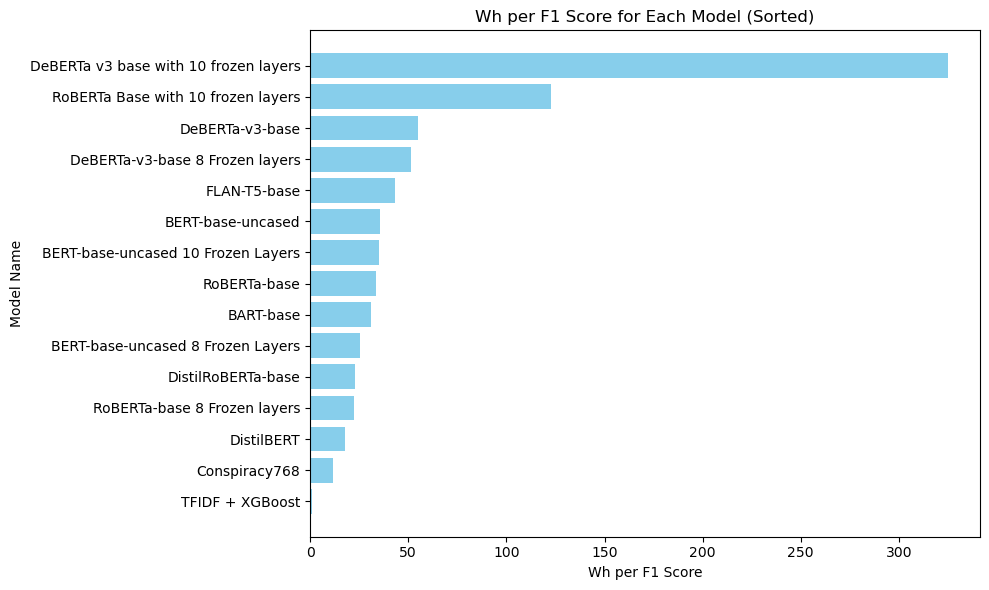

In [4]:
# Sort the dataframe by the 'wh_per_f1' column
df_sorted_wh_per_f1 = raw_df.sort_values(by='wh_per_f1')

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted_wh_per_f1['model_name'], df_sorted_wh_per_f1['wh_per_f1'], color='skyblue')
plt.xlabel('Wh per F1 Score')
plt.ylabel('Model Name')
plt.title('Wh per F1 Score for Each Model (Sorted)')
plt.tight_layout()
plt.show()

## Plot Training & F1 

In [7]:
raw_df[(~raw_df['model_architecture'].isin(['LLM'])) & (~raw_df['model_name'].str.contains('Frozen'))][['model_name', 'f1_score']].sort_values(by='f1_score', ascending=False).reset_index(drop=True)

,model_name,f1_score
0,DeBERTa-v3-base,0.725827
1,RoBERTa-base,0.721745
2,FLAN-T5-base,0.720856
3,BART-base,0.714571
4,DistilBERT,0.693330
5,BERT-base-uncased,0.690056
6,TFIDF + XGBoost,0.577948
7,Conspiracy768,0.555116
8,DistilRoBERTa-base,0.545114
9,RoBERTa Base with 10 frozen layers,0.101332


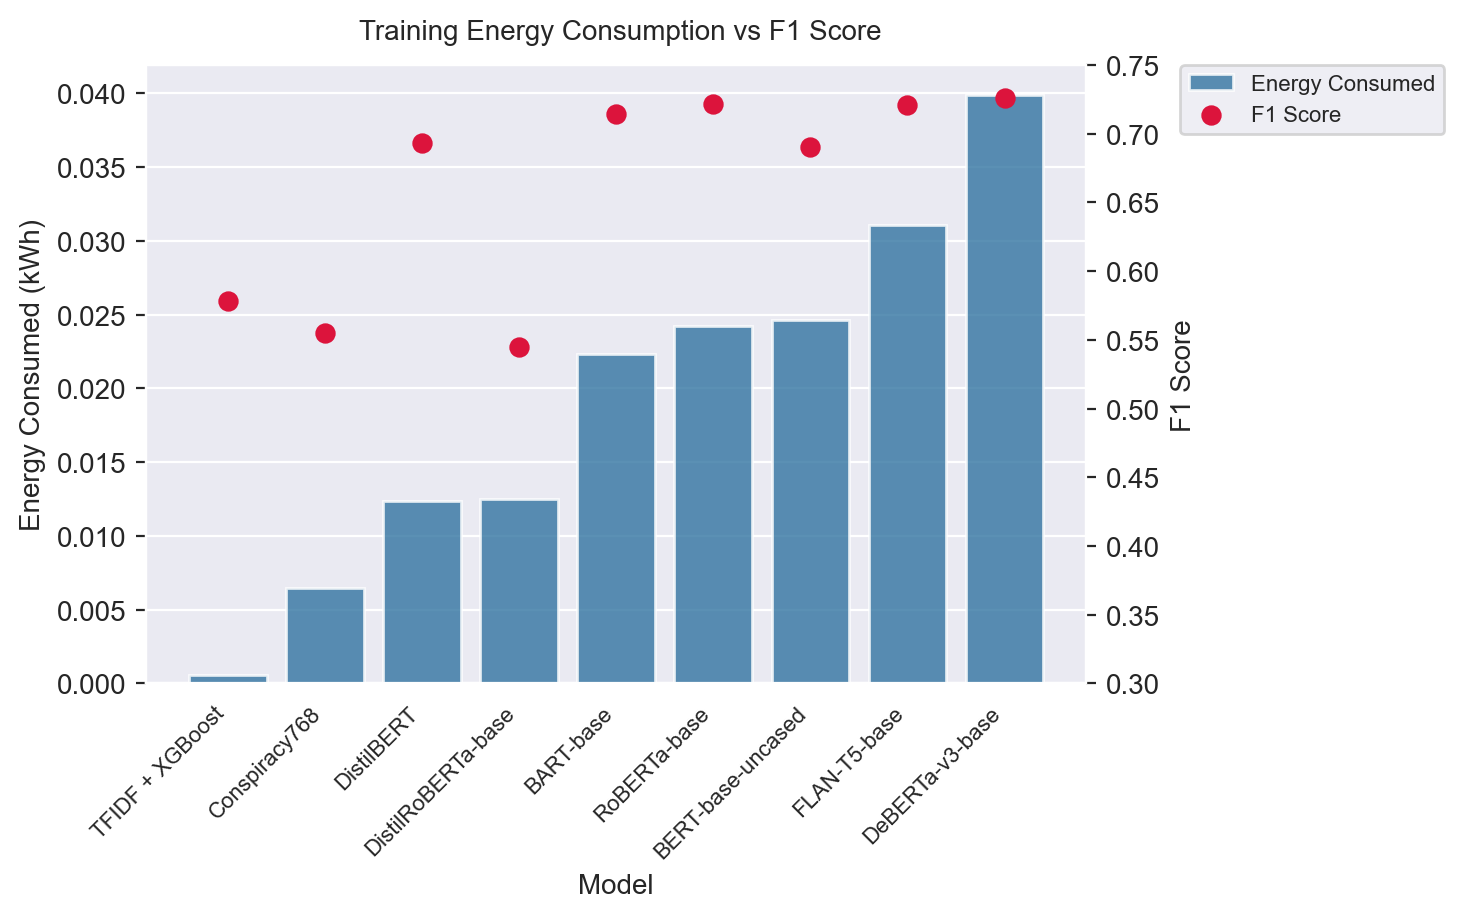

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter and sort DataFrame
plot_df = (
    raw_df[
        ~raw_df['model_architecture'].isin(['LLM']) &
        ~raw_df['model_name'].str.lower().str.contains('frozen')
    ]
    .sort_values(by='energy_consumed_kwh')
)

# Determine consistent order for x-axis
model_order = plot_df['model_name'].tolist()

# Apply Seaborn darkgrid style
sns.set_style('darkgrid')

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(9, 5), dpi=200)
ax1.set_axisbelow(True)  # draw grid below bars

# Plot energy bars with darker palette and fixed order
sns.barplot(
    x='model_name',
    y='energy_consumed_kwh',
    data=plot_df,
    ax=ax1,
    alpha=0.8,
    zorder=3,
    order=model_order,
    label='Energy Consumed'
)

# Secondary axis for F1 Score
ax2 = ax1.twinx()

# Plot F1 scatter on top using same x-order positions
x_positions = list(range(len(model_order)))
for x_pos, (_, row) in zip(x_positions, plot_df.iterrows()):
    ax2.scatter(
        x_pos,
        row['f1_score'],
        s=40,
        color='crimson',
        zorder=4,
        label='F1 Score' if x_pos == 0 else ''  # label only once
    )

# Axis labels and tick styling
ax1.set_xlabel('Model', fontsize=10)
ax1.set_ylabel('Energy Consumed (kWh)', fontsize=10)
ax2.set_ylabel('F1 Score', fontsize=10)

# Set x-ticks to numeric positions and label them
ax1.set_xticks(x_positions)
ax1.set_xticklabels(model_order, rotation=45, ha='right', size=8)

# Remove grid from secondary axis
ax2.grid(False)
ax2.set_ylim(0.3, 0.75)

# Combine legends from both axes and place outside plot
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc='upper left',
    bbox_to_anchor=(1.1, 1),
    borderaxespad=0,
    fontsize=8,
)

# Title and layout adjustments
fig.suptitle('Training Energy Consumption vs F1 Score', fontsize=10, y=0.91, x=0.35)
plt.tight_layout(rect=[0, 0, 0.85, 0.96])  # leave space on right for legend

# Save and show
plt.savefig(
    '../results/energy_vs_f1_score.png',
    dpi=200,
    bbox_inches='tight',
    transparent=False
)
plt.show()


## Plot frozen energy

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


In [11]:
df_plot = raw_df.copy()
df_plot['model_type'] = df_plot['model_name'].apply(
    lambda x: 'Frozen' if 'Frozen' in x else 'Base'
)
df_plot.head()

,model_name,base_model,Frozen layers,total_params,trainable_params,model_architecture,inf_sample_size,batch_size,epochs,location,...,inf_gpu_energy_kwh,inf_ram_energy_kwh,inf_hardware,inf_location,accuracy,f1_score,total_params_numeric,trainable_params_numeric,wh_per_f1,model_type
0,TFIDF + XGBoost,XGBoost,0,~1K–10K,~1K–10K,Traditional ML (TFIDF + Trees),1000,NaN,NaN,SGP,...,9.577785e-07,5.598067e-07,"[RAM(), CPU(Intel(R) Xeon(R) CPU @ 2.20GHz > 8...",SGP,0.584906,0.577948,1000,1000,0.968620,Base
1,BERT-base-uncased,BERT-base-uncased,Base,~110M,~110M,Encoder (BERT-style),1000,32.0,5.0,SGP,...,1.402312e-04,3.982994e-05,"[RAM(), CPU(Intel(R) Xeon(R) CPU @ 2.20GHz > 8...",SGP,0.693191,0.690056,110000000,110000000,35.678404,Base
2,BERT-base-uncased 10 Frozen Layers,BERT-base-uncased,10,~110M,~20M,Encoder (BERT-style),1000,32.0,5.0,CAN,...,1.459479e-04,4.072773e-05,"[RAM(), CPU(Intel(R) Xeon(R) CPU @ 2.20GHz > 8...",SGP,0.458573,0.408231,110000000,20000000,35.226955,Frozen
3,BERT-base-uncased 8 Frozen Layers,BERT-base-uncased,8,~110M,~34M,Encoder (BERT-style),1000,32.0,5.0,SGP,...,1.395290e-04,3.946068e-05,"[RAM(), CPU(Intel(R) Xeon(R) CPU @ 2.20GHz > 8...",SGP,0.663659,0.662430,110000000,34000000,25.535404,Frozen
4,DistilBERT,DistilBERT,0,~66M,~66M,Encoder (BERT-style),1000,32.0,5.0,SGP,...,6.852478e-05,1.967267e-05,"[RAM(), CPU(Intel(R) Xeon(R) CPU @ 2.20GHz > 8...",SGP,0.695652,0.693330,66000000,66000000,17.805193,Base


In [12]:
base_model_names = df_plot[(df_plot['Frozen layers']=='Base')]['base_model']

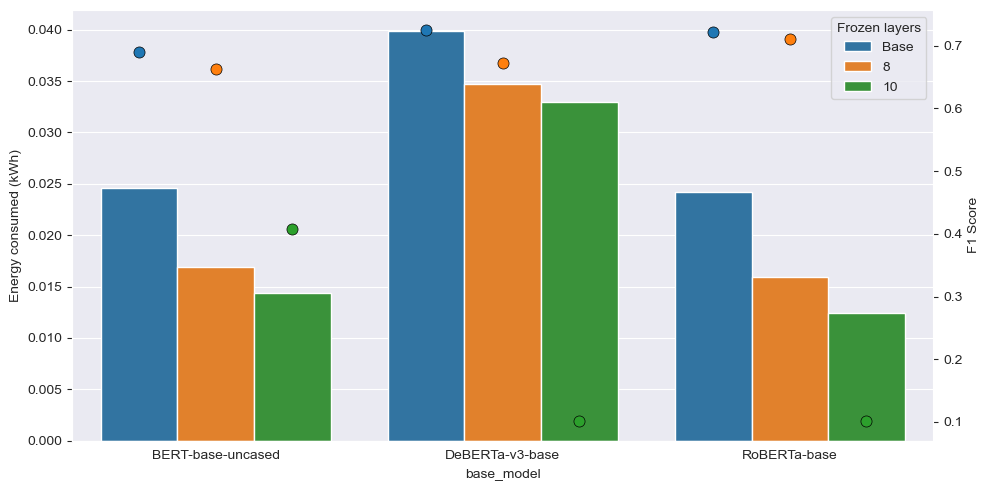

In [13]:
# 1. Ensure 'Frozen layers' are strings and ordered:
df_plot['Frozen layers'] = df_plot['Frozen layers'].astype(str)
hue_order = ['Base', '8', '10']
palette = 'tab10'

# 2. Draw the barplot for energy consumed:
g = sns.catplot(
    data=df_plot[df_plot.base_model.isin(base_model_names)],
    x='base_model', y='energy_consumed_kwh',
    hue='Frozen layers', hue_order=hue_order,
    kind='bar', palette=palette,
    height=5, aspect=2, legend_out=False
)
ax = g.ax
ax.set_ylabel('Energy consumed (kWh)')

# 3. Create a twin y-axis for f1_score:
ax2 = ax.twinx()
ax2.set_ylabel('F1 Score')
ax2.grid(False)  # remove grid from secondary axis

# 4. Overlay one point per bar, dodged to line up with each hue category:
sns.stripplot(
    data=df_plot[df_plot.base_model.isin(base_model_names)],
    x='base_model', y='f1_score',
    hue='Frozen layers', hue_order=hue_order,
    palette=palette, dodge=True, ax=ax2,
    marker='o', size=8, edgecolor='black', linewidth=0.5,
    legend=False   # disable a second legend
)

# 5. Finalize legends: keep just the bar legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Frozen layers', loc='upper right')

plt.tight_layout()
plt.show()

In [20]:
sns.set_style(None)

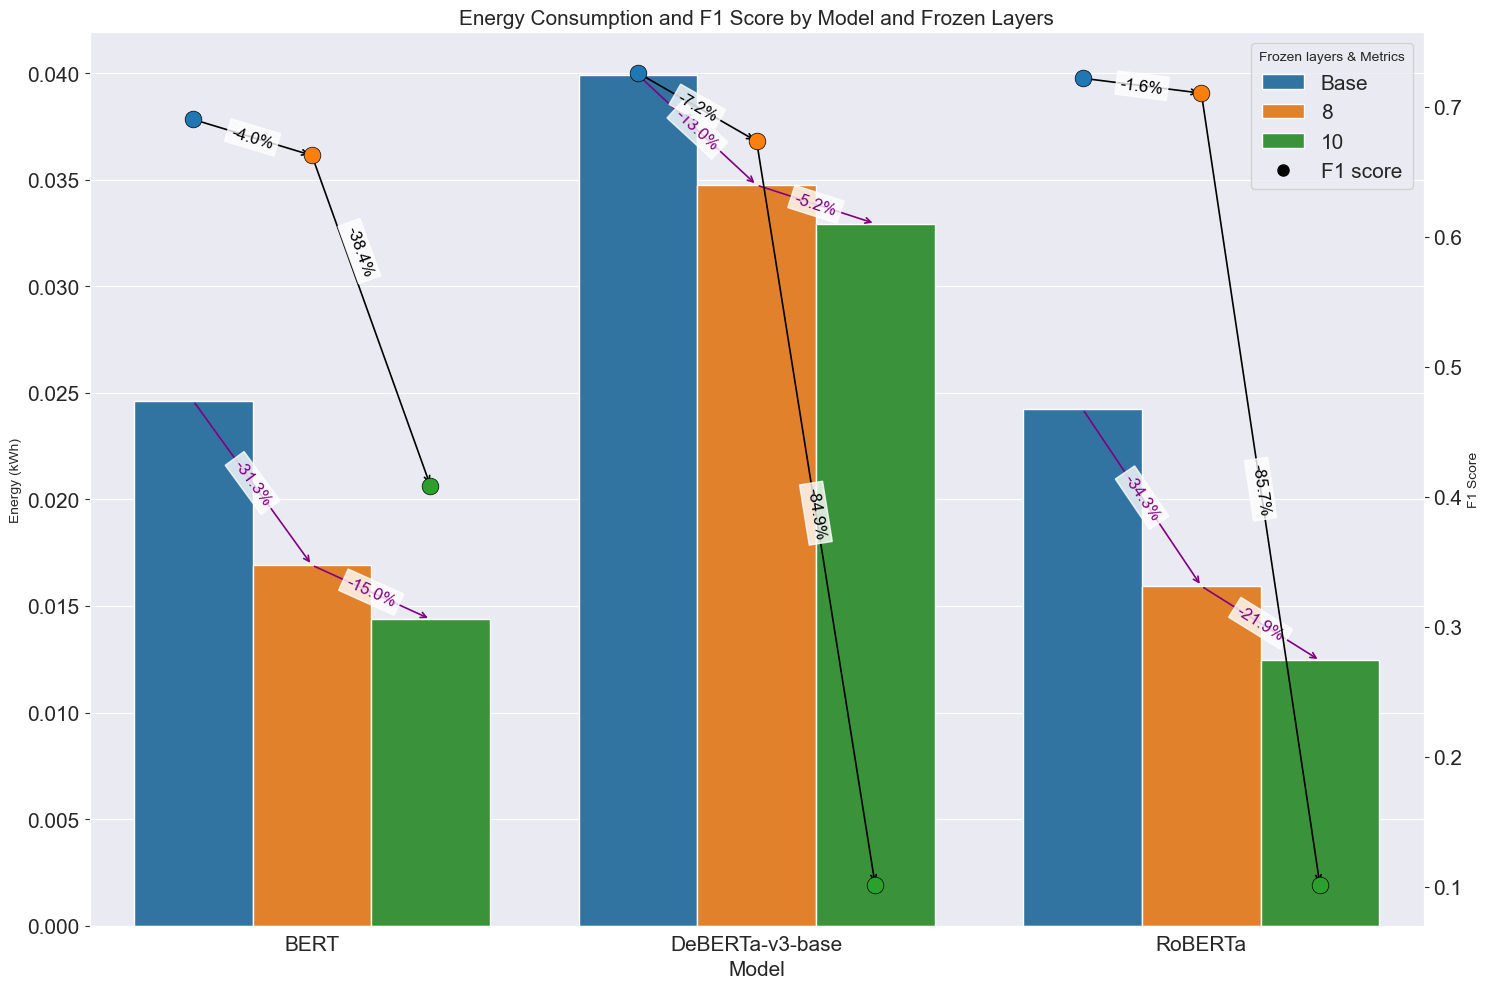

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch


# 1. Prepare data
df = df_plot.copy()
df = df[df['base_model'].isin(base_model_names)]
df['Frozen layers'] = df['Frozen layers'].astype(str)
hue_order = ['Base', '8', '10']

# 1a. Map to shorter model names:
short_map = {
    'BERT-base-uncased':'BERT',
    'RoBERTa-base':'RoBERTa',
    'DistilBERT':'DistilBERT',
    'DistilRoBERTa-base':'DistilRoBERTa',
    'ConspiracyBERT':'C-BERT',
    'BBERTa-v3-base':'BBERTa-v3',
    'XGBoost':'XGBoost',
    'LAN-T5-base':'T5'
}
df['model_short'] = df['base_model'].map(short_map).fillna(df['base_model'])

models = list(dict.fromkeys(df['model_short']))  # preserve appearance order

# Pivot tables for lookups
energy_pivot = df.pivot_table(index='model_short', columns='Frozen layers',
                              values='energy_consumed_kwh')
f1_pivot    = df.pivot_table(index='model_short', columns='Frozen layers',
                              values='f1_score')

# 2. Draw bar + strip plots
fig, ax = plt.subplots(figsize=(15, 10), dpi=100)
g = sns.barplot(
    data=df, x='model_short', y='energy_consumed_kwh',
    order=models, hue='Frozen layers', hue_order=hue_order,
    palette='tab10', ax=ax,)
ax.set_ylabel('Energy (kWh)')

ax2 = ax.twinx()
ax2.set_ylabel('F1 Score')
# ax2.set(ylim=(0.38,0.8))
sns.stripplot(
    data=df, x='model_short', y='f1_score',
    order=models, hue='Frozen layers', hue_order=hue_order,
    palette='tab10', dodge=True, ax=ax2,
    marker='o', size=12, edgecolor='black', linewidth=0.5,
    legend=False
)

# 3. Compute offsets for arrows
xticks    = ax.get_xticks()
bar_width = ax.patches[0].get_width()
n_hues    = len(hue_order)
offsets   = [-bar_width*(n_hues-1)/2 + j*bar_width for j in range(n_hues)]

texts = []
# 4. Annotate arrows + percentage labels with white boxes
for i, model in enumerate(models):
    for j in range(n_hues-1):
        h1, h2 = hue_order[j], hue_order[j+1]
        x1 = xticks[i] + offsets[j]
        x2 = xticks[i] + offsets[j+1]

        # F1
        f1_1 = f1_pivot.loc[model, h1]
        f1_2 = f1_pivot.loc[model, h2]
        if pd.isna(f1_1) or pd.isna(f1_2):
            continue
        ax2.annotate('', xy=(x2,f1_2), xytext=(x1,f1_1),
                     arrowprops=dict(arrowstyle='->', lw=1.2, color='black'),
                     zorder=1)
        pct_f1 = (f1_1-f1_2)/f1_1*100 if f1_1!=0 else 0
        dp1f = ax2.transData.transform((x1,f1_1))
        dp2f = ax2.transData.transform((x2,f1_2))
        ang_f1 = np.degrees(np.arctan2(dp2f[1]-dp1f[1], dp2f[0]-dp1f[0]))
        mx2 = (x1+x2)/2
        my2 = (f1_1+f1_2)/2
        if model == 'BERT' and j == 1:
            mx2 *= 0.8
            my2 *= 1.1

        t = ax2.text(mx2, my2, f"-{pct_f1:.1f}%",
                 ha='center', va='center',
                 rotation=ang_f1, rotation_mode='anchor',
                 fontsize=12, color='black',
                 bbox=dict(facecolor='white', alpha=0.8, pad=3),
                 zorder=10)
        texts.append(t)

        # Energy
        y1 = energy_pivot.loc[model, h1]
        y2 = energy_pivot.loc[model, h2]
        if pd.isna(y1) or pd.isna(y2): 
            continue

        ax.annotate('', xy=(x2,y2), xytext=(x1,y1),
                    arrowprops=dict(arrowstyle='->', lw=1.2, color='purple'),
                    zorder=1)
        pct_e = (y1-y2)/y1*100 if y1!=0 else 0
        dp1 = ax.transData.transform((x1,y1))
        dp2 = ax.transData.transform((x2,y2))
        ang_e = np.degrees(np.arctan2(dp2[1]-dp1[1], dp2[0]-dp1[0]))
        mx1 = (x1+x2)/2
        my1 = (y1+y2)/2

        t = ax.text(mx1, my1, f"-{pct_e:.1f}%",
                ha='center', va='center',
                rotation=ang_e, rotation_mode='anchor',
                fontsize=12, color='purple',
                bbox=dict(facecolor='white', alpha=0.8, pad=3),
                zorder=20)
        texts.append(t)

 
        

# 5. Build a combined legend including the dot for F1 score
handles, labels = ax.get_legend_handles_labels()
dot_handle = Line2D([0], [0],
                    marker='o', color='black',
                    label='F1 score',
                    markersize=8, linestyle='')
handles.append(dot_handle)
labels.append('F1 score')

# ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(handles, labels, title='Frozen layers & Metrics', loc='upper right', fontsize=15)
ax.set_xlabel('Model', fontsize=15)
ax.set_title('Energy Consumption and F1 Score by Model and Frozen Layers', fontsize=15)
ax.set_axisbelow(True)
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.grid(False)  # remove grid from secondary axis


plt.tight_layout()
plt.show()

fig.savefig('../results/energy_f1_plot.png', dpi=100)


In [ ]:
# Filter the data for the specific base model
base_model = "BERT-base-uncased"
subset = df_plot[df_plot['base_model'] == base_model]

# Extract energy consumption values
base_energy = subset[subset['Frozen layers'] == 'Base']['energy_consumed_kwh'].values[0]
frozen_8_energy = subset[subset['Frozen layers'] == '8']['energy_consumed_kwh'].values[0]
frozen_10_energy = subset[subset['Frozen layers'] == '10']['energy_consumed_kwh'].values[0]

# Calculate reductions
reduction_8 = base_energy - frozen_8_energy
reduction_10 = frozen_8_energy - frozen_10_energy

reduction_8_percentage = (reduction_8 / base_energy) * 100
reduction_10_percentage = (reduction_10 / frozen_8_energy) * 100

print(f"Reduction from Base to 8 Frozen Layers: {reduction_8:.6f} kWh ({reduction_8_percentage:.2f}%)")
print(f"Reduction from 8 to 10 Frozen Layers: {reduction_10:.6f} kWh ({reduction_10_percentage:.2f}%)")

print(f"Reduction from Base to 8 Frozen Layers: {reduction_8:.6f} kWh")
print(f"Reduction from 8 to 10 Frozen Layers: {reduction_10:.6f} kWh")

Reduction from Base to 8 Frozen Layers: 0.007705 kWh (31.29%)
Reduction from 8 to 10 Frozen Layers: 0.002535 kWh (14.98%)


## Model Frontier

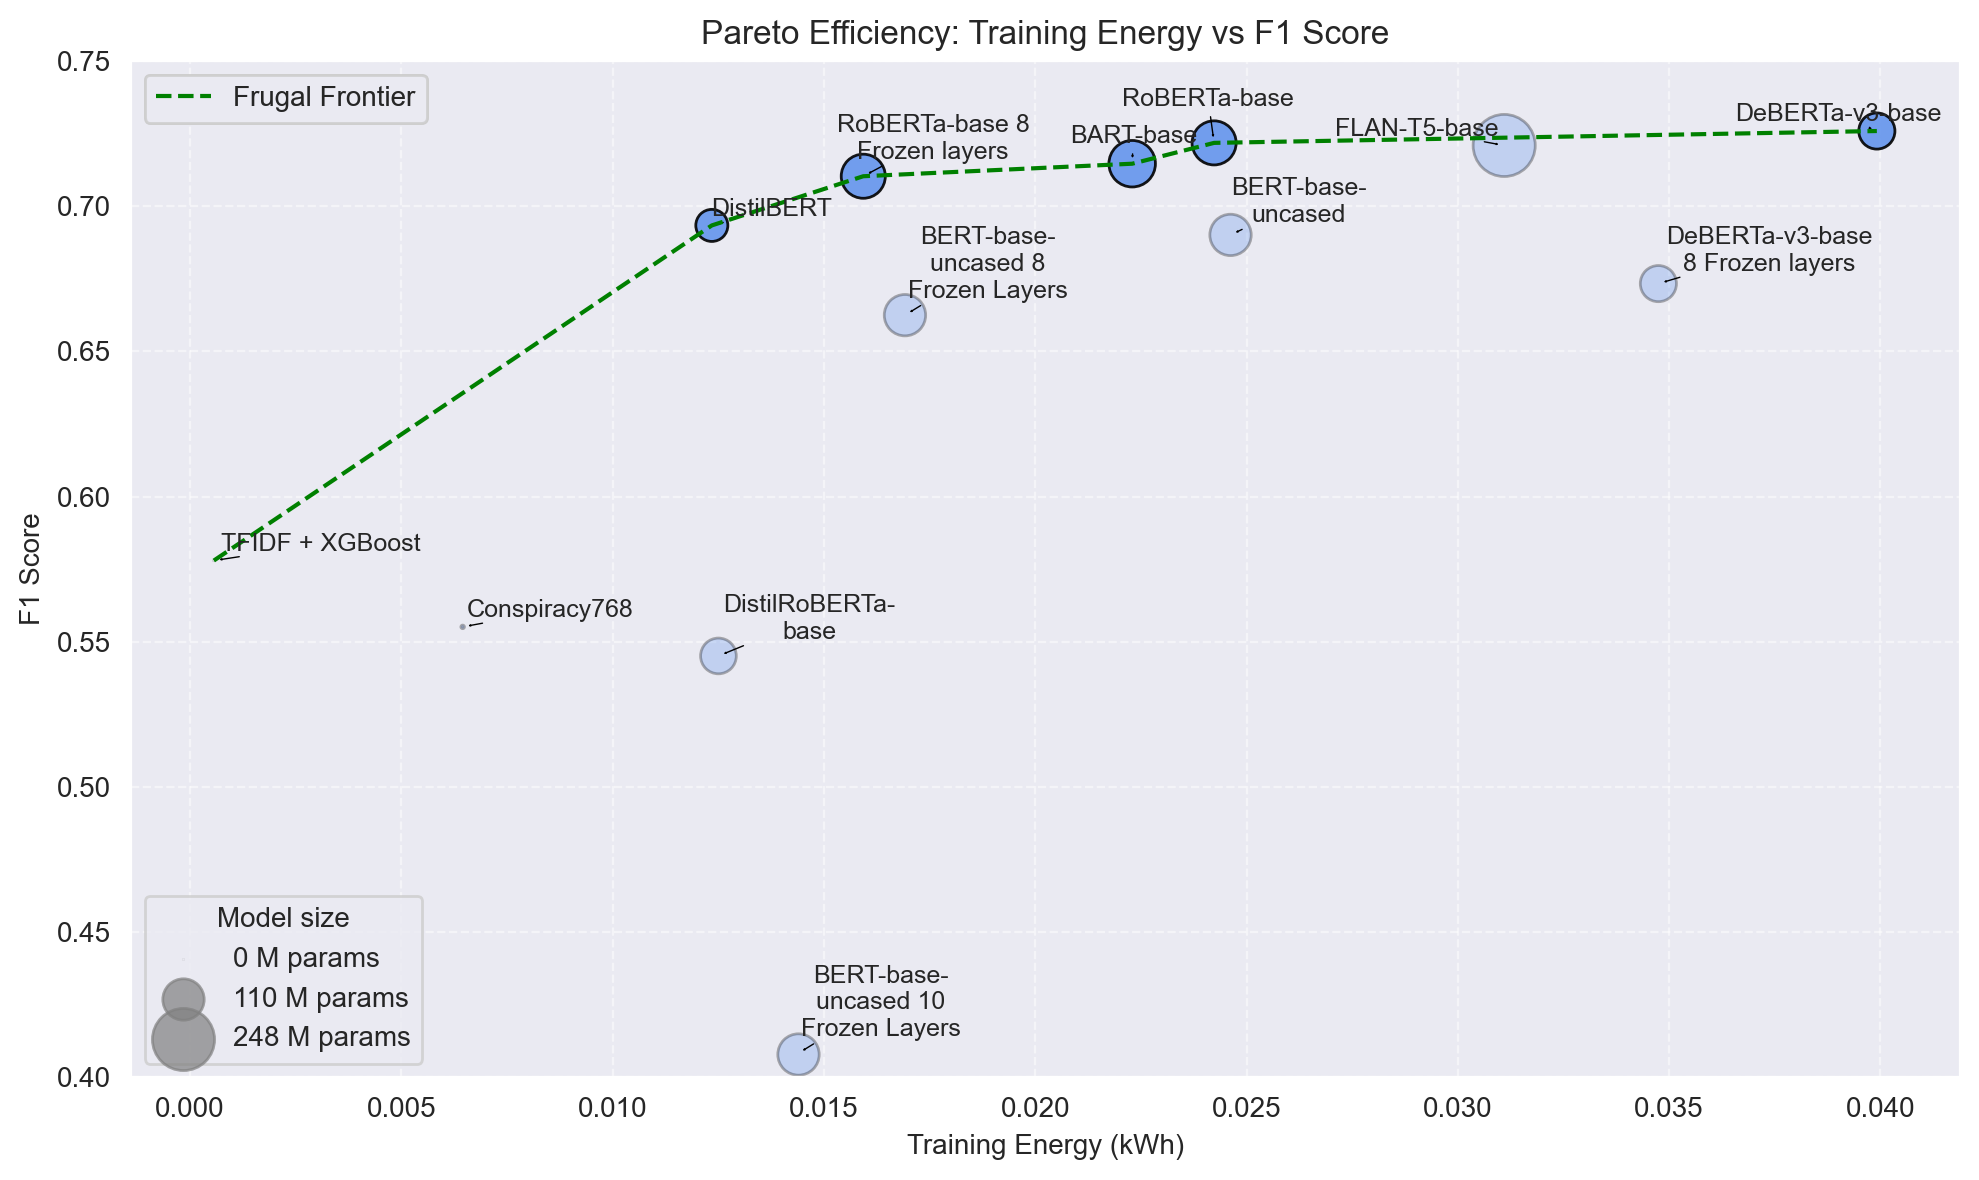

In [ ]:
import textwrap
from adjustText import adjust_text
import matplotlib.pyplot as plt
import pandas as pd

# 0) Copy + rename
pareto_plot_df = raw_df.copy()
pareto_plot_df = pareto_plot_df[pareto_plot_df['f1_score'] > 0.4]
pareto_plot_df.rename(columns={'Frozen layers':'frozen_layers',
                               'model_name':'model_name',
                               'total_params_numeric':'total_params_numeric',
                               'energy_consumed_kwh':'energy_consumed_kwh',
                               'f1_score':'f1_score'},
                      inplace=True)

# 1) Wrap long names
pareto_plot_df['wrapped'] = pareto_plot_df['model_name'].apply(
    lambda x: '\n'.join(textwrap.wrap(x, width=15))
)

# 2) Compute Pareto frontier
# df_sorted = pareto_plot_df.sort_values('energy_consumed_kwh')
# pareto_pts, best_f1 = [], 0
# for _, row in df_sorted.iterrows():
#     if row['f1_score'] > best_f1:
#         pareto_pts.append(row)
#         best_f1 = row['f1_score']
# pareto_df = pd.DataFrame(pareto_pts)
# frontier_set = set(pareto_df.index)

df_sorted = pareto_plot_df.sort_values('energy_consumed_kwh')
train_pareto_pts = []
best_acc = 0
highest_energy = 0
for _, row in df_sorted.iterrows():
    if row['f1_score'] > best_acc and row['energy_consumed_kwh'] > highest_energy:
        train_pareto_pts.append(row)
        best_acc = row['f1_score']
        highest_energy = row['energy_consumed_kwh']
pareto_df = pd.DataFrame(train_pareto_pts)
frontier_set = set(pareto_df.index)

inf_df_sorted = pareto_plot_df.sort_values('inf_energy_consumed_kwh')
inf_pareto_pts = []
best_acc = 0
highest_energy = 0
for _, row in inf_df_sorted.iterrows():
    if row['f1_score'] > best_acc and row['inf_energy_consumed_kwh'] > highest_energy:
        inf_pareto_pts.append(row)
        best_acc = row['f1_score']
        highest_energy = row['inf_energy_consumed_kwh']
inf_pareto_df = pd.DataFrame(inf_pareto_pts)
inf_frontier_set = set(pareto_df.index)

# 3) Size scale
max_params = pareto_plot_df['total_params_numeric'].max()
pareto_plot_df['size'] = pareto_plot_df['total_params_numeric'] / max_params * 500

# 4) Marker shapes for freeze configs
marker_map = {'Base':'o', '8':'s', '10':'^'}

# 5) Plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.grid(True, linestyle='--', alpha=0.5)

# plot each config, dim non-frontier points
for cfg, grp in pareto_plot_df.groupby('frozen_layers'):
    is_front = grp.index.isin(frontier_set)
    ax.scatter(
        grp['energy_consumed_kwh'],
        grp['f1_score'],
        s=grp['size'],
        alpha=[0.9 if i else 0.3 for i in is_front],
        # label=f'{cfg} frozen layers',
        color='cornflowerblue',
        edgecolor='k'  # to help see shape
    )

# 6) Annotate only Pareto points
texts = []
for row in pareto_plot_df.itertuples():
    texts.append(
        ax.text(
            row.energy_consumed_kwh,
            row.f1_score,
            row.wrapped,
            fontsize=9,
            ha='center'
        )
    )
adjust_text(texts, ax=ax,
            arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# 7) Frontier line
ax.plot(pareto_df['energy_consumed_kwh'],
        pareto_df['f1_score'],
        '--', color='green', label='Frugal Frontier')

# 8) Bubble‐size legend
# pick representative sizes: min, median, max
p_min = pareto_plot_df['total_params_numeric'].min()
p_med = pareto_plot_df['total_params_numeric'].median()
p_max = max_params

s_min = p_min / max_params * 500
s_med = p_med / max_params * 500
s_max = 500

size_handles = [
    ax.scatter([], [], s=s_min, color='gray', alpha=0.7),
    ax.scatter([], [], s=s_med, color='gray', alpha=0.7),
    ax.scatter([], [], s=s_max, color='gray', alpha=0.7),
]
size_labels = [f'{int(p_min/1e6)} M params',
               f'{int(p_med/1e6)} M params',
               f'{int(p_max/1e6)} M params']
legend2 = ax.legend(size_handles, size_labels,
                    title='Model size', loc='lower left', frameon=True)

# 9) Final styling
ax.set_xlabel('Training Energy (kWh)')
ax.set_ylabel('F1 Score')
ax.set_title('Pareto Efficiency: Training Energy vs F1 Score')

# combine and show
leg1 = ax.legend(loc='upper left', title='', frameon=True)
ax.add_artist(leg1)
ax.add_artist(legend2)
ax.set_ylim(0.4, 0.75)
# ax.set_aspect('auto')

plt.tight_layout()
plt.savefig('../results/pareto_efficiency.png', dpi=200, bbox_inches='tight')
plt.show()


In [55]:
df = df[~df['model_architecture'].isin(['LLM'])]

df = df.sort_values(by='energy_consumed_kwh')
df = df[df['accuracy'] > 0.6]

# Create figure
fig = go.Figure()

# Bar chart: Energy consumed
fig.add_trace(go.Bar(
    x=df['model_name'],
    y=df['energy_consumed_kwh'],
    name='Energy Consumed (kWh)',
    yaxis='y1'
))

# Line chart: F1 Score
fig.add_trace(go.Scatter(
    x=df['model_name'],
    y=df['f1_score'],
    name='F1 Score',
    yaxis='y2',
    mode='markers',
    marker=dict(size=12)
))

# Layout with dual Y-axes
fig.update_layout(
    title='Energy Consumption vs F1 Score per Model',
    xaxis=dict(title='Model'),
    yaxis=dict(
        title='Energy (kWh)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue')
    ),
    yaxis2=dict(
        title='F1 Score',
        titlefont=dict(color='red'),
        tickfont=dict(color='red'),
        overlaying='y',
        side='right'
    ),
    legend=dict(x=1.05, y=1.0),  # Move legend outside the chart area
    bargap=0.2,
    width=900,
    height=500
)

fig.show()


In [56]:
df[['training_time', 'energy_consumed_kwh']].corr()

,training_time,energy_consumed_kwh
training_time,1.000000,0.999765
energy_consumed_kwh,0.999765,1.000000


In [26]:
import pandas as pd
import plotly.graph_objects as go

df = pd.read_excel("../frugal_model_results.xlsx", sheet_name="model_results")
df.rename(columns={'energy_consumed_kwh': 'training_energy_kwh', 'inf_energy_consumed_kwh':'inference_energy_kwh'}, inplace=True)
df = df[~df['model_architecture'].isin(['LLM'])]
df = df.sort_values(by='training_energy_kwh')

# Create figure
fig = go.Figure()

# Bar chart: Training energy consumed
fig.add_trace(go.Bar(
    x=df['model_name'],
    y=df['training_energy_kwh'],
    name='Training Energy (kWh)',
    yaxis='y1',
    marker_color='blue',
    offsetgroup='group1'
))

# Bar chart: Inference energy consumed
fig.add_trace(go.Bar(
    x=df['model_name'],
    y=df['inference_energy_kwh'],
    name='Inference Energy (kWh)',
    yaxis='y2',
    marker_color='orange',
    offsetgroup='group2'
))

# Layout with dual Y-axes
fig.update_layout(
    title='Training vs Inference Energy Consumption per Model',
    xaxis=dict(title='Model'),
    yaxis=dict(
        title='Training Energy (kWh)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue')
    ),
    yaxis2=dict(
        title='Inference Energy (kWh/1K inference)',
        titlefont=dict(color='orange'),
        tickfont=dict(color='orange'),
        overlaying='y',
        side='right'
    ),
    barmode='group',
    legend=dict(x=0.01, y=0.99),
    bargap=0.2,
    width=900,
    height=500
)

fig.show()
# fig.write_image("../results/training_vs_inference_energy.png", width=900, height=500, scale=2)

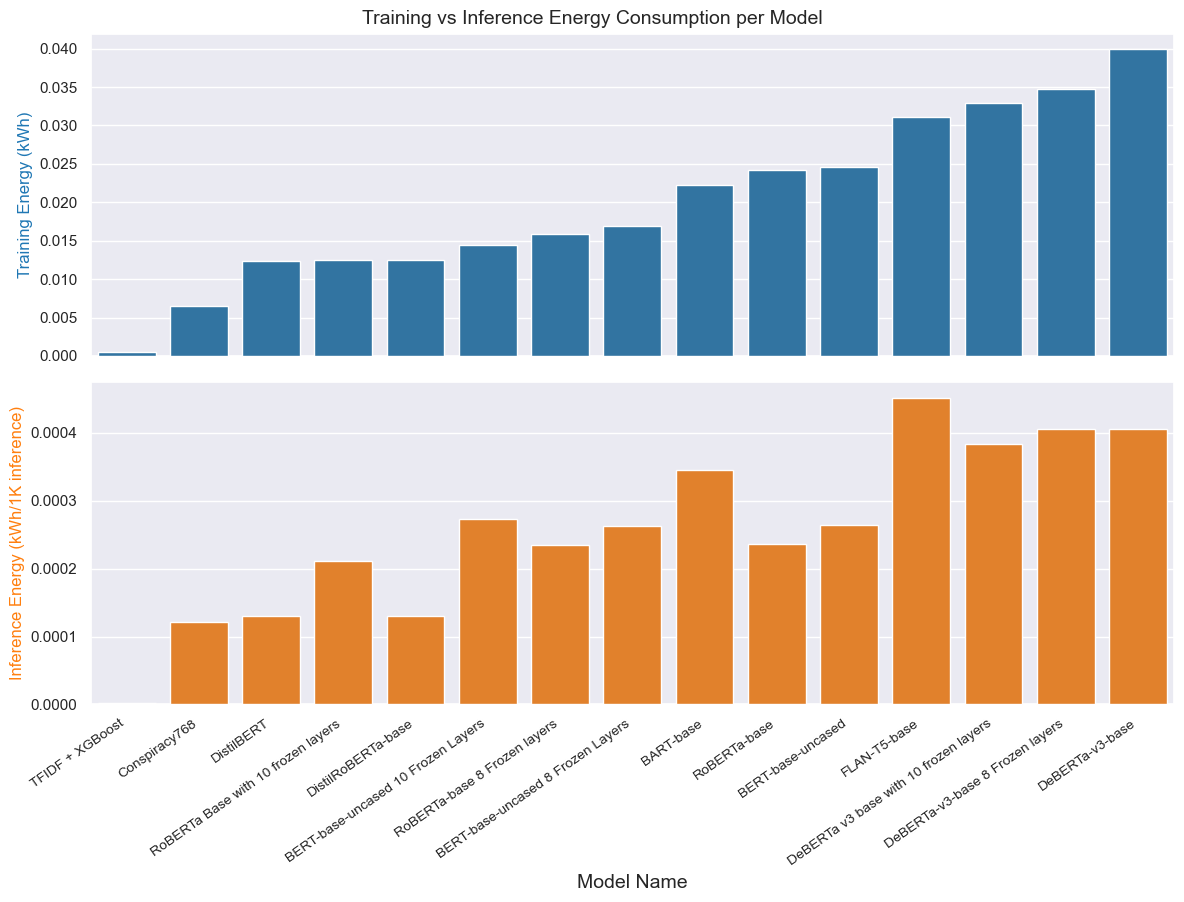

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load & prep
df = pd.read_excel("../frugal_model_results.xlsx", sheet_name="model_results")
df = df.rename(columns={
    'energy_consumed_kwh':     'training_energy_kwh',
    'inf_energy_consumed_kwh': 'inference_energy_kwh'
})
df = df[~df['model_architecture'].isin(['LLM'])]
df = df.sort_values(by='training_energy_kwh').reset_index(drop=True)

# 2. Styling
sns.set_theme(style="darkgrid")
palette = sns.color_palette("tab10", n_colors=2)

# 3. Prepare the fixed category order
model_order = df['model_name'].tolist()
n = len(model_order)

# 4. Create 2-panel figure
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 10),
    dpi=100,
    sharex=True
)

# 5. Plot training energy
sns.barplot(
    x='model_name',
    y='training_energy_kwh',
    data=df,
    ax=ax1,
    order=model_order,
    color=palette[0],
    zorder=3
)
ax1.set_ylabel("Training Energy (kWh)", color=palette[0])

# 6. Plot inference energy
sns.barplot(
    x='model_name',
    y='inference_energy_kwh',
    data=df,
    ax=ax2,
    order=model_order,
    color=palette[1],
    zorder=3
)
ax2.set_ylabel("Inference Energy (kWh/1K inference)", color=palette[1])

# 7. Ticks & labels only on bottom axis
ax2.set_xticks(np.arange(n))
ax2.set_xticklabels(model_order, rotation=35, ha='right', fontsize=10)

ax2.set_xlabel("Model Name", fontsize=14)

# 8. Remove x-tick labels from top panel
# ax1.set_xticklabels([])

# 9. Title & layout
fig.suptitle("Training vs Inference Energy Consumption per Model", y=0.9, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("../results/training_vs_inference_energy.png", dpi=300)
plt.show()




In [ ]:
# Assume df has columns: 'training_energy_kwh', 'inference_energy_kwh', 'f1_score'
df = raw_df.copy()

# 1. Choose weights (they must sum to 1)
alpha = 0.3   # weight for F1 score
beta  = 0.6   # weight for training energy
gamma = 0.3  # weight for inference energy

# 2. Compute mins and maxes
F_min, F_max = df['f1_score'].min(), df['f1_score'].max()
T_min, T_max = df['energy_consumed_kwh'].min(), df['energy_consumed_kwh'].max()
I_min, I_max = df['inf_energy_consumed_kwh'].min(), df['inf_energy_consumed_kwh'].max()

# 3. Normalize and invert energies
df['f1_norm']   = (df['f1_score'] - F_min) / (F_max - F_min)
df['train_norm'] = (df['energy_consumed_kwh'] - T_min) / (T_max - T_min)
df['inf_norm']   = (df['inf_energy_consumed_kwh'] - I_min) / (I_max - I_min)

df['train_inv'] = 1 - df['train_norm']
df['inf_inv']   = 1 - df['inf_norm']

# 4. Compute weighted frugal rating
df['frugal_rating'] = (
      alpha * df['f1_norm']
    + beta  * df['train_inv']
    + gamma * df['inf_inv']
)

In [ ]:
df[['model_name', 'frugal_rating']].sort_values(by='frugal_rating', ascending=False)

,model_name,frugal_rating
0,TFIDF + XGBoost,0.928960
4,DistilBERT,0.782773
5,Conspiracy768,0.755734
10,DistilRoBERTa-base,0.710112
9,RoBERTa-base 8 Frozen layers,0.655754
8,RoBERTa-base,0.617287
3,BERT-base-uncased 8 Frozen Layers,0.596800
1,BERT-base-uncased,0.568847
12,BART-base,0.502728
2,BERT-base-uncased 10 Frozen Layers,0.476011
